# Project 6: Hierarchical Clustering

We decided to use the **[User Knowledge Modeling Dataset](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)** which ranks the students' knowledge status about the subject of Electrical DC Machines of the of Department of Electrical Education of Gazi University in the 2009 semester. The are 4 knowledge levels (**very low**, **low**, **middle** and **high**). The class distribution is presented below:

- **Very low**: 50
- **Low**: 129
- **Middle**: 122
- **High**: 130

The number of the **total** samples is 403 (both training and testing data). Since, we are insterested in clustering, we combine the two datasets. Each sample has 5 attributes, which are the following:

- **STG** (The degree of study time for goal object materials),
- **SCG** (The degree of repetition number of user for goal object materials)
- **STR** (The degree of study time of user for related objects with goal object)
- **LPR** (The exam performance of user for related objects with goal object)
- **PEG** (The exam performance of user for goal objects)

**UNS** is the correct knowledge level of user.

In [1]:
%matplotlib inline
import matplotlib.pylab

In [2]:
import numpy as np
data = np.recfromcsv('user_knowledge_modeling_hamdi.csv', delimiter=',')

# split attributes from correct class
labels = np.array([ row[5] for row in data ])
data = data[['stg', 'scg', 'str', 'lpr', 'peg']]

In [3]:
print (len(data))
print (len(data.dtype.names))

403
5


In [4]:
data_array = data.view((np.float, len(data.dtype.names)))
#data_array = data_array.transpose()

Let's have a look at how our data actually looks like

In [5]:
print (data_array)

[[ 0.    0.    0.    0.    0.  ]
 [ 0.08  0.08  0.1   0.24  0.9 ]
 [ 0.06  0.06  0.05  0.25  0.33]
 ..., 
 [ 0.56  0.6   0.77  0.13  0.32]
 [ 0.66  0.68  0.81  0.57  0.57]
 [ 0.68  0.64  0.79  0.97  0.24]]


## Samples clustering using `scipy`

We'll implement the clustering using `scipy` modules. First we import the necessary methods:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

There are many methods for calculating the distance between the clusters. Let's try first the *single* linkage method:

In [7]:
data_dist = pdist(data_array)  # computing the distance
data_link = linkage(data_dist, method='single') # computing the linkage

Now, let's plot the dendrogram:

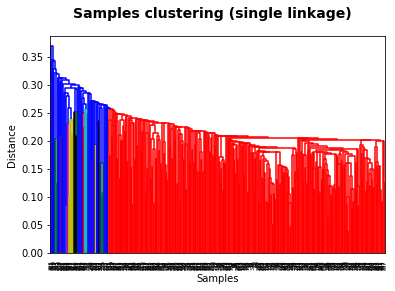

In [8]:
dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering (single linkage)', fontweight='bold', fontsize=14);

As we already know, there should be 4 clusters in total (one for each knowledge level). Judging from the dendrogram produced, the *single* linkage method doesn't work well for our data. It has found over 10 clusters (each cluster is denoted by a separate color), where the "red" one is about $80\%$ of all the samples.

Let's try the *complete* linkage method:

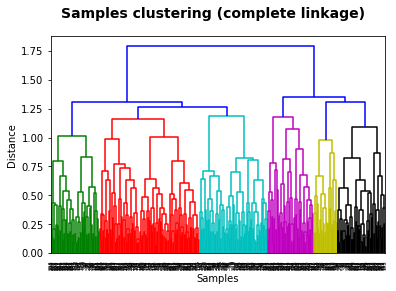

In [9]:
data_link = linkage(data_dist, method='complete') # computing the linkage

dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering (complete linkage)', fontweight='bold', fontsize=14);

The *complete* linkage method produces a much better clustering for our data. Each cluster has a decent number of points and the whole clustering result is acceptable.

Let's do on final try using the *ward* linkage method which uses the [*Ward variance minimization algorithm*](https://en.wikipedia.org/wiki/Ward's_method). Instead of relying on the minimum or maximum distance between two clusters (*single* and *complete* linkage methods respectively), we try to minimize the **total within-cluster variance** every time we merge two clusters:

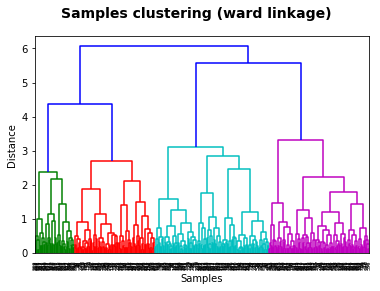

In [10]:
data_link = linkage(data_dist, method='ward') # computing the linkage

dendrogram(data_link)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering (ward linkage)', fontweight='bold', fontsize=14);

The *Ward's method* produces an even better and cleaner clustering, if we were to judge its quality from the difference in the heights in the last few clustering steps. We can see that the heigh difference for the last 3 steps is over $50\%$ of the overall heigh. **Thus, these clusters look very solid.**

Plotting a heatmap that many R users are used to is a tricky endevour in Python

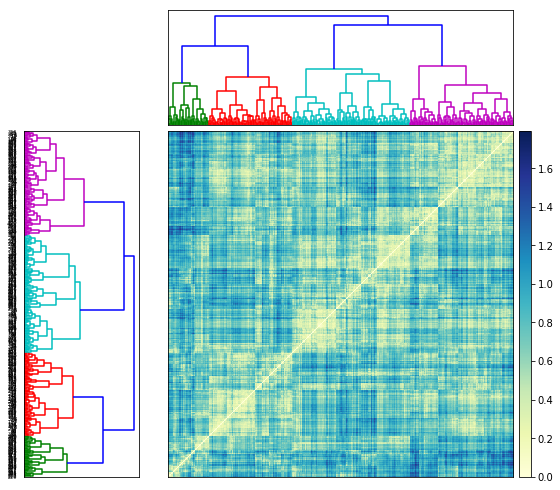

In [11]:
# Compute and plot first dendrogram.
fig = plt.figure(figsize=(8,8))

# x ywidth height
ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
Z1 = dendrogram(data_link, orientation='right')
ax1.set_xticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = dendrogram(data_link)
ax2.set_xticks([])
ax2.set_yticks([])

# Compute and plot the heatmap
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = squareform(data_dist)
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)

Another thing you can and should definitely do is check the Cophenetic Correlation Coefficient of your clustering with help of the cophenet() function. This (very very briefly) compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in our case is pretty close:

In [12]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

X = data_array

# Compute Cophenetic Correlation Coefficient
for method in ['single', 'complete', 'ward']:
    Z = linkage(X, method=method)
    c, coph_dists = cophenet(Z, pdist(data_array))
    print('%s: %f' % (method, c))

single: 0.481245
complete: 0.476758
ward: 0.475410


The values for the different clustering methods are very close, thus we cannot say there is a best method, solely based on the *Coephenetic Correlation Coefficient*.

Let's check now what kinds of elements the **`Z`** array contains: 

In [13]:
Z[0]

array([  8.30000000e+01,   1.00000000e+02,   3.74165739e-02,
         2.00000000e+00])

No matter what method and metric you pick, the `linkage()` function will use that method and metric to calculate the distances of the clusters (starting with your n individual samples (data points) as singleton clusters)) and in each iteration will merge the two clusters which have the smallest distance according the selected method and metric. It will return an array of length $n - 1$ giving you information about the $n - 1$ cluster merges which it needs to pairwise merge n clusters. $Z[i]$ will tell us which clusters were merged in the $i-th$ iteration, let's take a look at the first two points that were merged:

We can see that ach row of the resulting array has the format `[idx1, idx2, dist, sample_count]`.

In its first iteration the linkage algorithm decided to merge the two clusters (original samples here) with indices **83** and **100**, as they only had a **ward's** distance of $0.03741$. This created a cluster with a total of 2 samples.

In [14]:
Z[1]

array([  9.80000000e+01,   1.02000000e+02,   4.69041576e-02,
         2.00000000e+00])

In the second iteration the algorithm decided to merge the clusters (original samples here as well) with indices **98** and **102**, which had a distance of $0.04690$. This again formed another cluster with a total of 2 samples.

The indices of the clusters until now correspond to our samples. Remember that we had a total of **403** samples, so indices 0 to 402. Let's have a look at the first 20 iterations:

In [15]:
Z[:20]

array([[  8.30000000e+01,   1.00000000e+02,   3.74165739e-02,
          2.00000000e+00],
       [  9.80000000e+01,   1.02000000e+02,   4.69041576e-02,
          2.00000000e+00],
       [  9.00000000e+01,   1.06000000e+02,   5.00399840e-02,
          2.00000000e+00],
       [  9.10000000e+01,   1.08000000e+02,   6.02079729e-02,
          2.00000000e+00],
       [  1.51000000e+02,   3.41000000e+02,   7.88733161e-02,
          2.00000000e+00],
       [  2.12000000e+02,   2.28000000e+02,   8.38152731e-02,
          2.00000000e+00],
       [  1.80000000e+01,   2.88000000e+02,   8.48528137e-02,
          2.00000000e+00],
       [  8.00000000e+00,   3.25000000e+02,   8.54400375e-02,
          2.00000000e+00],
       [  3.84000000e+02,   3.88000000e+02,   8.66025404e-02,
          2.00000000e+00],
       [  2.74000000e+02,   3.44000000e+02,   8.71779789e-02,
          2.00000000e+00],
       [  2.15000000e+02,   2.31000000e+02,   8.79829529e-02,
          2.00000000e+00],
       [  1.55000000e

We can observe that until iteration **19** the algorithm only directly merged original samples. We can also observe the monotonic increase of the ward's distance. In iteration **19** the algorithm decided to merge cluster indices **171** with **414**. If you paid attention the **414** should astonish you as we only have original sample indices 0 to 402 for our 403 samples. All indices $idx >= len(X)$ actually refer to the cluster formed in $Z[idx - len(X)]$.

This means that while idx 402 corresponds to X[402] that idx 403 corresponds to the cluster formed in Z[0], idx 404 to Z[1], 405 to Z[2], ...

Hence, the merge iteration **19** merged sample **171** to our samples **155** and **156** that were previously merged in iteration 11.

Let's check out the points coordinates to see if this makes sense:

In [16]:
X[[171, 155, 156]]

array([[ 0.43 ,  0.38 ,  0.62 ,  0.33 ,  0.49 ],
       [ 0.44 ,  0.32 ,  0.55 ,  0.33 ,  0.52 ],
       [ 0.45 ,  0.299,  0.63 ,  0.36 ,  0.51 ]])

Seems pretty close, but let's plot the points again and highlight them. Since our points/samples have 5 attributes (and thus they belong to the $R^5$ space), we can not directly visualize the produced clusters. A partial solution to this problem would be to use *PCA* to move to the $R^2$ space:

In [17]:
from sklearn.decomposition import PCA

# apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print (X_pca.shape)  # 403 samples with 2 dimensions

(403, 2)


Now let's plot these above points:

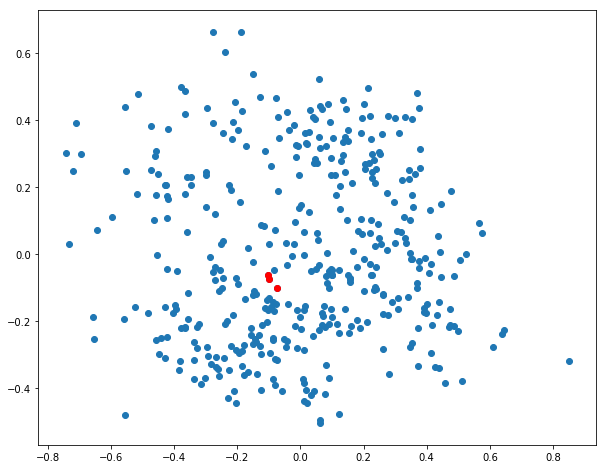

In [18]:
idxs = [171, 155, 156]
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:,0], X_pca[:,1])  # plot all points
plt.scatter(X_pca[idxs,0], X_pca[idxs,1], c='r')  # plot interesting points in red again
plt.show()

**Dendrogram visualization**

A dendrogram is a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering. Let's plot again the dendrogram in a bigger box:

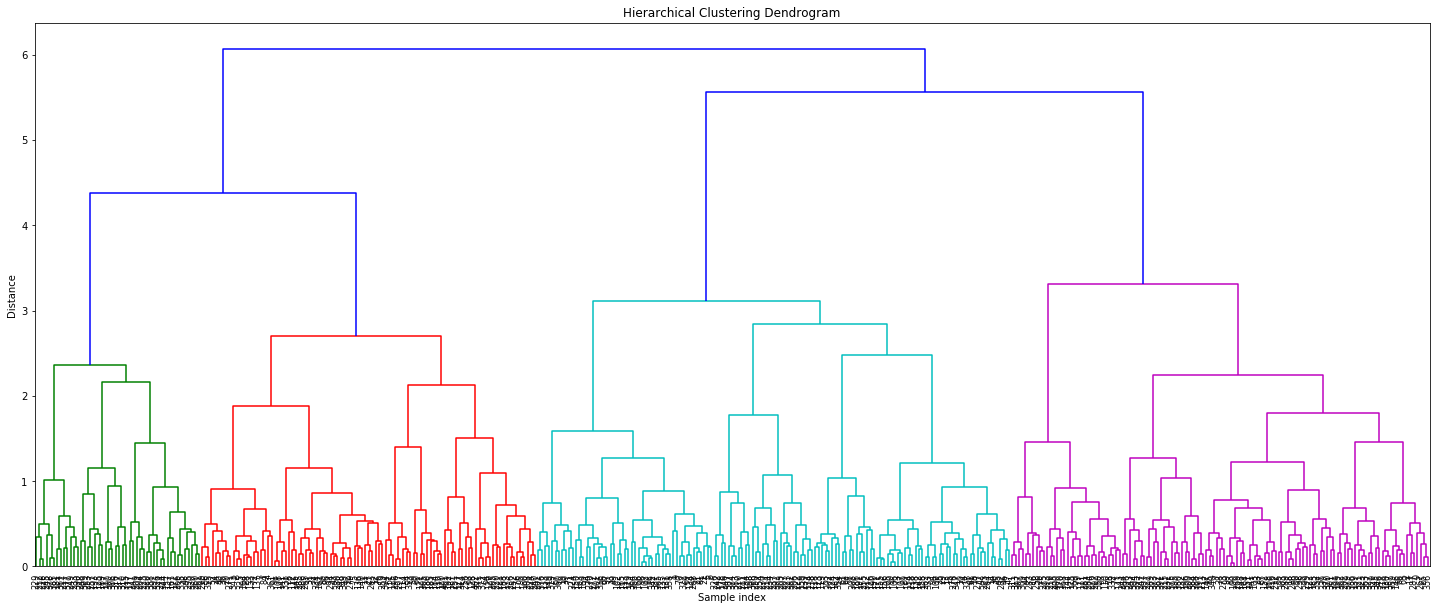

In [19]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

If this is the first time you see a dendrogram, it's probably quite confusing, so let's take this apart...

- Horizontal lines are cluster merges
- Vertical lines tell you which clusters/labels were part of merge forming that new cluster
- Heights of the horizontal lines tell you about the distance that needed to be "bridged" to form the new cluster

You can also see that from distances $\gt 3$ up there's a big jump of the distance to the final merge at a distance of approx. 6. Let's have a look at the distances of the last 4 merges:

In [20]:
Z[-4:, 2]

array([ 3.31011732,  4.38303816,  5.56105871,  6.07039088])

In case you're wondering about where the colors come from, you might want to have a look at the color_threshold argument of dendrogram(), which as not specified automagically picked a distance cut-off value of 70 % of the final merge and then colored the first clusters below that in individual colors.

**Dendrogram Truncation**

As you might have noticed, the above is pretty big for **403** samples already and you probably have way more in real scenarios, so let me spend a few seconds on highlighting some other features of the dendrogram() function:

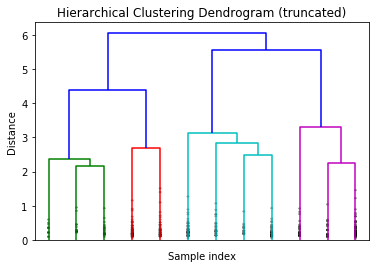

In [21]:
# Truncated dendrogram
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12, # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

The above shows a truncated dendrogram, which only shows the last $p=12$ out of our 402 merges.

The parameter `show_contracted` allows us to draw black dots at the heights of those previous cluster merges, so we can still spot gaps even if we don't want to clutter the whole visualization. In our example we can see that the dots are all at pretty small distances (i.e $ \lt 2$) when compared to the last merge at a distance of 6, telling us that we probably didn't miss much there.

As it's kind of hard to keep track of the cluster sizes just by the dots, `dendrogram()` will by default also print the cluster sizes in brackets () if a cluster was truncated:

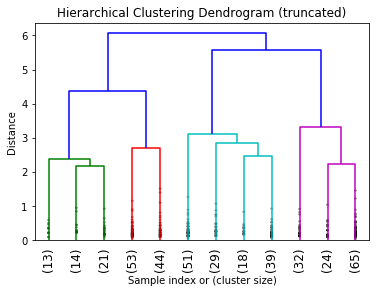

In [22]:
# Truncated dendrogram with cluster sizes
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

We can now see the sizes of the clusters before the last 12 merges. The left-most cluster is the smallest one, with **13** points, and the right-most is the larges one with **65** points/samples.

**Eye Candy**

Even though this already makes for quite a nice visualization, we can pimp it even more by also annotating the distances inside the dendrogram by using some of the useful return values `dendrogram()`:

In [23]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('Sample index or (cluster size)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

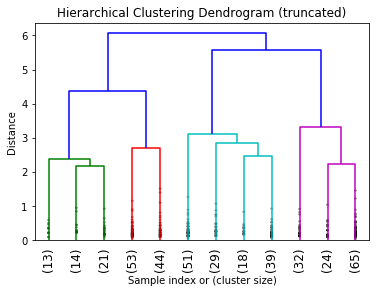

In [24]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

**Selecting a Distance Cut-Off aka Determining the Number of Clusters**

As explained above already, a big jump in distance is typically what we're interested in if we want to argue for a certain number of clusters. In our case we would probably just say that our cut-off is **3.5**, as we are interested in a small number of clusters:

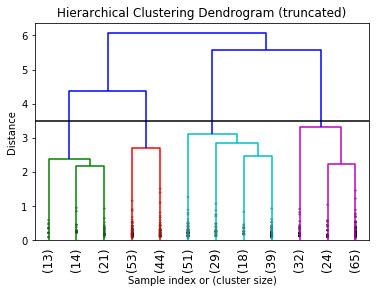

In [25]:
# set cut-off to 3.5
max_d = 3.5  # max_d as in max_distance
#Let's visualize this in the dendrogram as a cut-off line:

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

As we can see, we end up with **four** clusters.

In general for a chosen cut-off value max_d you can always simply count the number of intersections with vertical lines of the dendrogram to get the number of formed clusters. Say we choose a cut-off of `max_d = 3`, we'd get 6 final clusters:

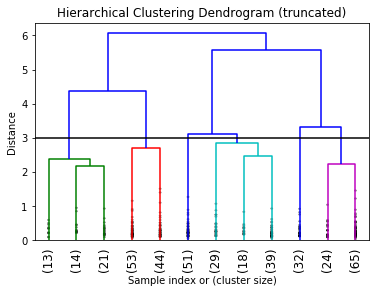

In [26]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=3,
)
plt.show()

**Automated Cut-Off Selection**

Now while this manual selection of a cut-off value offers a lot of benefits when it comes to checking for a meaningful clustering and cut-off, there are cases in which you want to automate this. The problem again is that there is no golden method to pick the number of clusters for all cases (which is why i think the investigative & backtesting manual method is preferable). Wikipedia lists a couple of common methods. Reading this, you should realize how different the approaches and how vague their descriptions are.


**Inconsistency Method**

For example, let's have a look at the "inconsistency" method, which seems to be one of the defaults for the `fcluster()` function in scipy.

The question driving the inconsistency method is "what makes a distance jump a jump?". It answers this by comparing each cluster merge's height h to the average avg and normalizing it by the standard deviation std formed over the depth previous levels:

`inconsistency = h − avgstd`

The following shows a matrix of the `avg, std, count, inconsistency` for each of the last 10 merges of our hierarchical clustering with depth = 5

In [27]:
from scipy.cluster.hierarchy import inconsistent

depth = 5
incons = inconsistent(Z, depth)
incons[-10:]

array([[  0.72330565,   0.48187186,  28.        ,   3.1456971 ],
       [  0.65636302,   0.57011651,  27.        ,   2.99879604],
       [  0.49582557,   0.45726312,  30.        ,   4.32834022],
       [  0.76795007,   0.59621182,  31.        ,   3.24763057],
       [  0.73440352,   0.61791025,  31.        ,   3.40849397],
       [  0.93910295,   0.72843353,  31.        ,   2.9899987 ],
       [  0.81048166,   0.6882967 ,  31.        ,   3.63162525],
       [  1.14783579,   0.87592356,  31.        ,   3.69347568],
       [  1.42301425,   1.10497345,  31.        ,   3.7449266 ],
       [  2.01744436,   1.34252867,  31.        ,   3.01889012]])

We can see that we can not use a certain number as a limit in the inconsistencies, as the inconsincency is not monotonically increasing.

Let's try with `depth = 3`:

In [28]:
depth = 3
incons = inconsistent(Z, depth)
incons[-10:]

array([[ 1.36857179,  0.53869601,  7.        ,  1.61604456],
       [ 1.31861926,  0.72443025,  7.        ,  1.44583537],
       [ 1.05876241,  0.68581824,  7.        ,  2.06505667],
       [ 1.66851876,  0.61486923,  7.        ,  1.68443465],
       [ 1.61147126,  0.77539647,  7.        ,  1.58509314],
       [ 1.97151267,  0.86699768,  7.        ,  1.32134792],
       [ 1.68796179,  0.86786864,  7.        ,  1.86912565],
       [ 2.37583873,  1.02966362,  7.        ,  1.94937396],
       [ 2.87345818,  1.38628801,  7.        ,  1.93870286],
       [ 3.93028218,  1.43993267,  7.        ,  1.48625609]])

Again, we fall into the same problem! 

**Elbow Method**

Another thing you might see out there is a variant of the "elbow method". It tries to find the clustering step where the acceleration of distance growth is the biggest (the "strongest elbow" of the blue line graph below, which is the highest value of the green graph below):

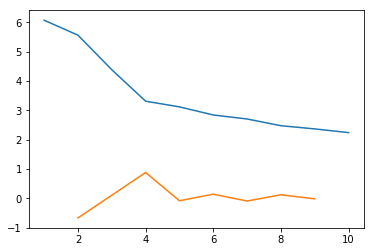

clusters: 4


In [29]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

Even though this works nicely in this example, it shouldn't be used blindly in every case. If we used this method on clusters produced by any other method (e.g. single, complete linkage), it isn't certain that it would give good results.

**Retrieve the Clusters**

Now, let's finally have a look at how to retrieve the clusters, for different ways of determining k. We can use the `fcluster` function.

**Knowing max_d:**
Let's say we determined the max distance with help of a dendrogram, then we can do the following to get the cluster id for each of our samples:

In [30]:
from scipy.cluster.hierarchy import fcluster

max_d = 4 # Max distance is set to 4
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([4, 3, 4, 2, 2, 3, 3, 4, 2, 3, 3, 2, 2, 3, 3, 3, 4, 4, 4, 3, 2, 3, 3,
       4, 2, 3, 4, 2, 2, 3, 3, 2, 2, 3, 3, 4, 2, 4, 4, 3, 2, 3, 3, 2, 4, 3,
       3, 3, 1, 3, 4, 2, 2, 3, 2, 4, 2, 3, 3, 2, 2, 3, 3, 2, 2, 4, 4, 3, 4,
       3, 3, 3, 2, 3, 3, 2, 2, 4, 4, 4, 2, 3, 3, 4, 2, 4, 3, 4, 2, 3, 3, 2,
       2, 4, 3, 2, 2, 3, 3, 4, 4, 3, 3, 4, 2, 3, 3, 3, 2, 3, 4, 4, 2, 3, 2,
       2, 2, 1, 3, 3, 2, 2, 4, 3, 3, 1, 3, 2, 2, 2, 4, 3, 4, 3, 3, 3, 2, 2,
       3, 4, 2, 2, 3, 4, 4, 2, 4, 4, 4, 3, 3, 4, 4, 2, 3, 3, 3, 1, 3, 3, 2,
       2, 3, 3, 4, 3, 3, 1, 4, 3, 4, 3, 1, 2, 3, 4, 2, 1, 3, 3, 2, 1, 3, 4,
       2, 2, 3, 2, 2, 1, 3, 3, 2, 1, 3, 4, 4, 4, 3, 4, 4, 3, 4, 3, 1, 2, 3,
       3, 2, 1, 3, 3, 1, 4, 3, 4, 4, 1, 3, 4, 2, 2, 3, 3, 2, 1, 3, 4, 1, 1,
       3, 4, 4, 1, 3, 4, 2, 3, 3, 3, 2, 1, 3, 4, 4, 1, 3, 4, 1, 1, 3, 2, 2,
       1, 3, 3, 2, 1, 4, 2, 1, 1, 3, 2, 3, 2, 1, 4, 3, 4, 3, 2, 3, 4, 1, 4,
       4, 3, 3, 2, 2, 4, 3, 4, 4, 2, 2, 4, 4, 4, 2, 1, 4, 3, 2, 1, 2, 2, 4,
       4, 1,

**Knowing k**: Another way starting from the dendrogram is to say "I can see I have `k = 4`" clusters, as in our example where we know beforehand the number of different clusters (i.e knowledge levels). You can then use:

In [31]:
k = 4
fcluster(Z, k, criterion='maxclust')

array([4, 3, 4, 2, 2, 3, 3, 4, 2, 3, 3, 2, 2, 3, 3, 3, 4, 4, 4, 3, 2, 3, 3,
       4, 2, 3, 4, 2, 2, 3, 3, 2, 2, 3, 3, 4, 2, 4, 4, 3, 2, 3, 3, 2, 4, 3,
       3, 3, 1, 3, 4, 2, 2, 3, 2, 4, 2, 3, 3, 2, 2, 3, 3, 2, 2, 4, 4, 3, 4,
       3, 3, 3, 2, 3, 3, 2, 2, 4, 4, 4, 2, 3, 3, 4, 2, 4, 3, 4, 2, 3, 3, 2,
       2, 4, 3, 2, 2, 3, 3, 4, 4, 3, 3, 4, 2, 3, 3, 3, 2, 3, 4, 4, 2, 3, 2,
       2, 2, 1, 3, 3, 2, 2, 4, 3, 3, 1, 3, 2, 2, 2, 4, 3, 4, 3, 3, 3, 2, 2,
       3, 4, 2, 2, 3, 4, 4, 2, 4, 4, 4, 3, 3, 4, 4, 2, 3, 3, 3, 1, 3, 3, 2,
       2, 3, 3, 4, 3, 3, 1, 4, 3, 4, 3, 1, 2, 3, 4, 2, 1, 3, 3, 2, 1, 3, 4,
       2, 2, 3, 2, 2, 1, 3, 3, 2, 1, 3, 4, 4, 4, 3, 4, 4, 3, 4, 3, 1, 2, 3,
       3, 2, 1, 3, 3, 1, 4, 3, 4, 4, 1, 3, 4, 2, 2, 3, 3, 2, 1, 3, 4, 1, 1,
       3, 4, 4, 1, 3, 4, 2, 3, 3, 3, 2, 1, 3, 4, 4, 1, 3, 4, 1, 1, 3, 2, 2,
       1, 3, 3, 2, 1, 4, 2, 1, 1, 3, 2, 3, 2, 1, 4, 3, 4, 3, 2, 3, 4, 1, 4,
       4, 3, 3, 2, 2, 4, 3, 4, 4, 2, 2, 4, 4, 4, 2, 1, 4, 3, 2, 1, 2, 2, 4,
       4, 1,

**Visualizing Your Clusters**

Since our data are 5-dimensional, we cannot directly visualize the resulting clusters. Although, we can use the 2-dimentional points produced by the $PCA$ to visualize the clusters in the 2D. Points with the same color belong to the same cluster:

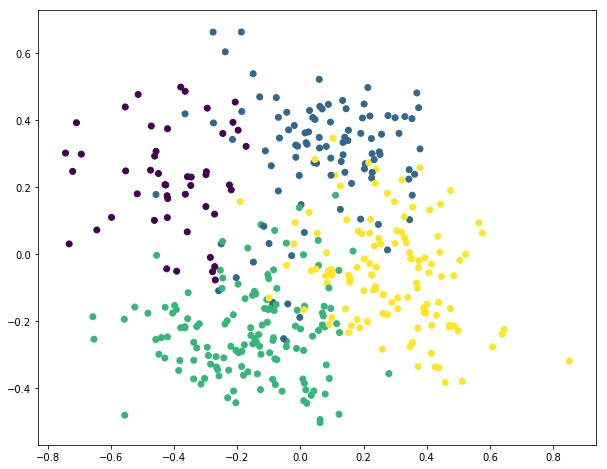

In [32]:
# Scatter plot of the PCA-ed samples
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)  # plot points with cluster dependent colors
plt.show()

We can see that some points of each cluster are located inside other clusters. This may look confusing at first, but it is totally normal. Remember that have lost some information from the $R^5 \to R^2$ transformation. Our clustering algorithms work on the original data dimension and they take into account information (i.e. point distances, variance of the cluster) that we cannot visualize. If our data were 2D then this plot would indicate that something went terribly wrong!

Finally, we can try to visualize the clusters in the 3D space to keep more info. We can achieve this by keeping one more components form the $PCA$ method:

In [33]:
# PCA: Keep 3 components from each sample
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(403, 3)


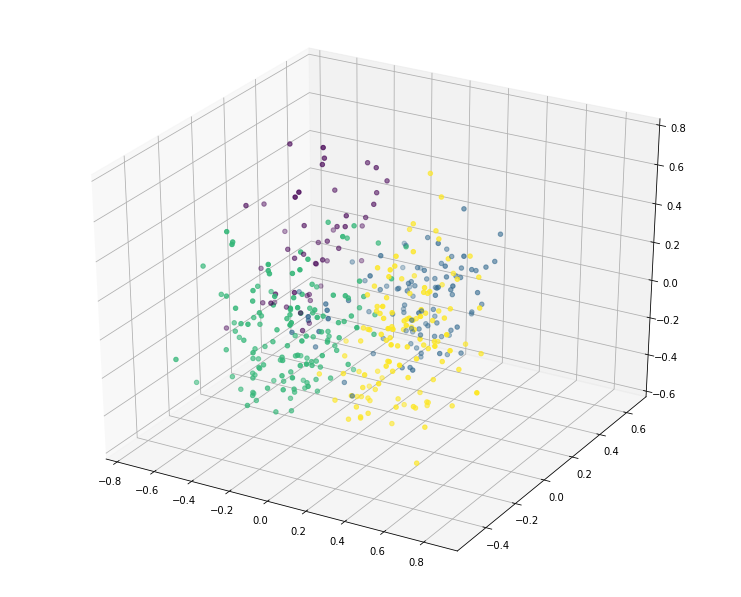

In [34]:
from mpl_toolkits.mplot3d import Axes3D

# Create new 3D figure
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

# Scatter plot of the 3D PCA-ed samples
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:, 2], c=clusters)  # plot points with cluster dependent colors
plt.show()

We can even plot an interactive 3d scatter plot!

<IPython.core.display.Javascript object>


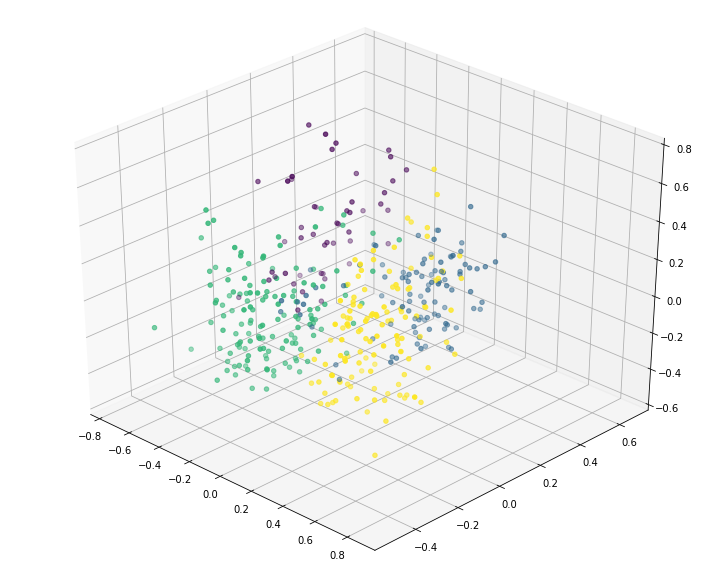

In [36]:
%matplotlib notebook

# Create new 3D figure
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig)

# Scatter plot of the 3D PCA-ed samples
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:, 2], c=clusters)  # plot points with cluster dependent colors
plt.show()